<a href="https://colab.research.google.com/github/VojtasekP/NAEX_reaction_time/blob/main/reaction_time_factorial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reaction Time Experiment: 2^k Factorial Design with Blocking

This notebook analyzes a reaction time experiment using a 2^7 factorial design with 4 operators as blocks.

## Experimental Design

### Factors (k = 7):
1. **Minimum delay**: -1 = 0.5s, +1 = 2.0s
2. **Maximum delay**: -1 = 3.0s, +1 = 7.0s
3. **Frame motion**: -1 = static, +1 = shaking
4. **Background**: -1 = white, +1 = random colors
5. **Font scale**: -1 = small, +1 = large
6. **Text color**: -1 = black, +1 = random colors
7. **Text motion**: -1 = static, +1 = moving

### Blocks (Operators):
- Sabina
- Florentin
- Francisco
- Petr

### Response:
- Reaction time (ms) - 10 repetitions per condition

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import OLSInfluence
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully")

Libraries loaded successfully


In [ ]:
import os
from io import StringIO

# Define file paths with local-first approach and GitHub fallback
data_files = {
    'Florentin': 'reaction_time_measurements_Florentin.csv',
    'Francisco': 'reaction_time_measurements_Francisco.csv',
    'Sabina': 'reaction_time_measurements_Sabina.csv',
    'Petr': 'reaction_time_petr.csv'
}

base_url = 'https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/'

dfs = []
for operator, filename in data_files.items():
    local_path = filename
    if os.path.exists(local_path):
        # Read raw content first to handle malformed files
        with open(local_path, 'r') as f:
            content = f.read()
        print(f"Loaded {operator} from local file: {local_path}")
    else:
        try:
            import urllib.request
            url = base_url + filename
            with urllib.request.urlopen(url) as response:
                content = response.read().decode('utf-8')
            print(f"Loaded {operator} from GitHub: {url}")
        except Exception as e:
            print(f"Error loading {operator}: {e}")
            continue

    # Fix malformed Sabina file: first line has multiple records concatenated
    # Split by the header pattern and reconstruct
    lines = content.split('\n')
    header = 'timestamp_utc,participant,stimulus_type,font_size,motion,input_mode,frame_motion,shaking,text_color_mode,background_mode,min_delay_sec,max_delay_sec,repetitions,trial,stimulus,reaction_time_ms'

    # Check if first line is malformed (contains multiple records)
    if lines[0].count('timestamp_utc') > 1 or lines[0].count(',') > 20:
        print(f"  -> Fixing malformed first line in {operator}'s file...")
        # The first line might have header + multiple data records concatenated
        # Split by the date pattern to separate records
        import re
        first_line = lines[0]
        # Extract header
        fixed_lines = [header]
        # Find all records (they start with date pattern)
        records = re.split(r'(?=\d{4}-\d{2}-\d{2}T)', first_line)
        for rec in records:
            if rec.strip() and not rec.startswith('timestamp'):
                fixed_lines.append(rec.strip())
        # Add remaining lines
        for line in lines[1:]:
            if line.strip():
                fixed_lines.append(line.strip())
        content = '\n'.join(fixed_lines)

    # Parse CSV
    df = pd.read_csv(StringIO(content))

    # Ensure participant column is consistent
    df['participant'] = operator
    dfs.append(df)
    print(f"  -> {len(df)} rows loaded for {operator}")

# Combine all data
df_raw = pd.concat(dfs, ignore_index=True)
print(f"\nTotal rows: {len(df_raw)}")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nRows per operator:")
print(df_raw['participant'].value_counts())

Loaded Florentin from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Florentin.csv
  -> 320 rows loaded for Florentin
Loaded Francisco from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Francisco.csv
  -> 320 rows loaded for Francisco
Loaded Sabina from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Sabina.csv
  -> 322 rows loaded for Sabina
Loaded Petr from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_petr.csv
  -> 328 rows loaded for Petr

Total rows: 1290
Columns: ['timestamp_utc', 'participant', 'stimulus_type', 'font_size', 'motion', 'input_mode', 'frame_motion', 'shaking', 'text_color_mode', 'background_mode', 'min_delay_sec', 'max_delay_sec', 'repetitions', 'trial', 'stimulus', 'reaction_time_ms']

Rows per operator:
participant
Petr         328
Sabina       322
Franci

In [ ]:
# Display first few rows
df_raw.head(10)

,timestamp_utc,participant,stimulus_type,font_size,motion,input_mode,frame_motion,shaking,text_color_mode,background_mode,min_delay_sec,max_delay_sec,repetitions,trial,stimulus,reaction_time_ms
0,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,1,C,2048.23
1,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,2,E,1227.94
2,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,3,V,1168.15
3,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,4,T,1121.69
4,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,5,A,897.19
5,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,6,F,826.01
6,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,7,D,889.86
7,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,8,O,1081.57
8,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,9,C,1154.58
9,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,10,O,1357.55


## 2. Data Preprocessing and Factor Coding

Convert the experimental settings to coded factor levels (-1, +1).

In [ ]:
# Create a copy for analysis
df = df_raw.copy()

# Code factors according to desc_factors.txt
# Factor 1: minimum delay (-1 = 0.5, +1 = 2.0)
df['A_min_delay'] = df['min_delay_sec'].apply(lambda x: -1 if x < 1.0 else 1)

# Factor 2: maximum delay (-1 = 3, +1 = 7)
df['B_max_delay'] = df['max_delay_sec'].apply(lambda x: -1 if x < 5.0 else 1)

# Factor 3: frame motion (-1 = static, +1 = shaking)
df['C_frame_motion'] = df['frame_motion'].apply(lambda x: 1 if 'Shaking' in str(x) else -1)

# Factor 4: background (-1 = white, +1 = random colors)
df['D_background'] = df['background_mode'].apply(lambda x: 1 if 'Random' in str(x) else -1)

# Factor 5: font scale (-1 = small, +1 = large)
df['E_font_scale'] = df['font_size'].apply(lambda x: 1 if 'Large' in str(x) else -1)

# Factor 6: text color (-1 = black, +1 = random)
df['F_text_color'] = df['text_color_mode'].apply(lambda x: 1 if 'Random' in str(x) else -1)

# Factor 7: text motion (-1 = static, +1 = moving)
df['G_text_motion'] = df['motion'].apply(lambda x: 1 if 'Moving' in str(x) else -1)

# Block: Operator/Participant
df['Block'] = df['participant']

# Response: reaction time
df['Y'] = df['reaction_time_ms']
df = df[df['trial']>2]
print("Factor coding complete")
print("\nFactor summary:")
for col in ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background', 'E_font_scale', 'F_text_color', 'G_text_motion']:
    print(f"{col}: {df[col].value_counts().to_dict()}")

Factor coding complete

Factor summary:
A_min_delay: {-1: 518, 1: 512}
B_max_delay: {-1: 518, 1: 512}
C_frame_motion: {-1: 518, 1: 512}
D_background: {1: 518, -1: 512}
E_font_scale: {-1: 518, 1: 512}
F_text_color: {1: 518, -1: 512}
G_text_motion: {1: 518, -1: 512}


In [ ]:
# Create unique experimental condition identifier
df['condition'] = (df['A_min_delay'].astype(str) + '_' +
                   df['B_max_delay'].astype(str) + '_' +
                   df['C_frame_motion'].astype(str) + '_' +
                   df['D_background'].astype(str) + '_' +
                   df['E_font_scale'].astype(str) + '_' +
                   df['F_text_color'].astype(str) + '_' +
                   df['G_text_motion'].astype(str))

# Count unique conditions per block
print("Unique conditions per block:")
print(df.groupby('Block')['condition'].nunique())

print(f"\nTotal unique conditions: {df['condition'].nunique()}")

Unique conditions per block:
Block
Florentin    32
Francisco    32
Petr         32
Sabina       32
Name: condition, dtype: int64

Total unique conditions: 128


## 3. Aggregate Data by Condition

Average reaction times over the 10 repetitions per condition.

In [ ]:
# Aggregate: mean reaction time per condition per block
factors = ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
           'E_font_scale', 'F_text_color', 'G_text_motion', 'Block']

df_agg = df.groupby(factors).agg(
    Y_mean=('Y', 'mean'),
    Y_median=('Y', 'median'),
    Y_std=('Y', 'std'),
    Y_count=('Y', 'count')
).reset_index()

print(f"Aggregated data shape: {df_agg.shape}")
print(f"\nConditions per block:")
print(df_agg.groupby('Block').size())

df_agg.head(10)

Aggregated data shape: (128, 12)

Conditions per block:
Block
Florentin    32
Francisco    32
Petr         32
Sabina       32
dtype: int64


,A_min_delay,B_max_delay,C_frame_motion,D_background,E_font_scale,F_text_color,G_text_motion,Block,Y_mean,Y_median,Y_std,Y_count
0,-1,-1,-1,-1,-1,-1,-1,Petr,801.93125,731.865,184.281302,8
1,-1,-1,-1,-1,-1,-1,1,Petr,1085.63250,1018.485,208.011396,8
2,-1,-1,-1,-1,-1,1,-1,Petr,1121.07500,1096.975,197.954460,8
3,-1,-1,-1,-1,-1,1,1,Francisco,798.95625,758.495,128.783889,8
4,-1,-1,-1,-1,1,-1,-1,Francisco,1043.24000,778.200,735.680174,8
5,-1,-1,-1,-1,1,-1,1,Petr,875.81875,860.785,64.496788,8
6,-1,-1,-1,-1,1,1,-1,Petr,936.38625,937.765,164.203748,8
7,-1,-1,-1,-1,1,1,1,Sabina,1001.45875,941.465,151.089039,8
8,-1,-1,-1,1,-1,-1,-1,Sabina,1017.84625,996.010,117.845237,8
9,-1,-1,-1,1,-1,-1,1,Francisco,842.95250,849.490,189.563080,8


In [ ]:
# @title
import pandas as pd
from io import StringIO

# --- 1. SETUP: READABLE LABELS ---
factor_labels = {
    0: {'name': 'MinDelay',    '-1': '0.5s',      '1': '2.0s'},
    1: {'name': 'MaxDelay',    '-1': '3.0s',      '1': '7.0s'},
    2: {'name': 'Frame',       '-1': 'Static',    '1': 'Shaking'},
    3: {'name': 'Background',  '-1': 'White',     '1': 'Random'},
    4: {'name': 'Font',        '-1': 'Small',     '1': 'Large'},
    5: {'name': 'TextColor',   '-1': 'Black',     '1': 'Random'},
    6: {'name': 'TextMotion',  '-1': 'Static',    '1': 'Moving'}
}

def decode_condition(cond_str):
    if pd.isna(cond_str): return "N/A"
    parts = cond_str.split('_')
    if len(parts) != 7: return cond_str
    readable = [factor_labels[i].get(part, part) for i, part in enumerate(parts)]
    return ", ".join(readable)

# --- 2. LOAD DOE TABLE ---
doe_string = """Operator,Run Order,minimum delay,motion,background,font scae,text color,frame motion,maximum delay
Sabina,1,1,-1,-1,-1,1,-1,1
Sabina,2,1,-1,1,1,-1,1,-1
Sabina,3,-1,-1,1,-1,1,1,-1
Sabina,4,1,-1,-1,-1,1,1,1
Sabina,5,1,1,-1,-1,1,-1,1
Sabina,6,1,-1,-1,-1,-1,1,1
Sabina,7,1,1,1,1,-1,-1,1
Sabina,8,-1,1,-1,-1,1,1,1
Sabina,9,-1,-1,1,-1,-1,1,-1
Sabina,10,1,-1,1,1,1,-1,-1
Sabina,11,-1,-1,1,-1,1,-1,1
Sabina,12,1,-1,1,-1,1,1,-1
Sabina,13,1,-1,1,1,-1,-1,1
Sabina,14,1,1,1,1,-1,1,1
Sabina,15,1,1,1,-1,1,-1,1
Sabina,16,1,1,1,1,-1,-1,-1
Sabina,17,-1,1,-1,1,1,-1,-1
Sabina,18,1,1,-1,-1,1,1,-1
Sabina,19,-1,1,1,1,-1,1,1
Sabina,20,-1,-1,1,-1,-1,-1,-1
Sabina,21,-1,-1,-1,1,1,1,1
Sabina,22,1,-1,-1,1,-1,1,1
Sabina,23,-1,1,1,-1,-1,1,1
Sabina,24,-1,-1,1,1,-1,1,-1
Sabina,25,1,-1,1,-1,1,1,1
Sabina,26,1,-1,-1,1,-1,-1,1
Sabina,27,-1,-1,-1,-1,-1,1,-1
Sabina,28,-1,-1,-1,1,1,1,-1
Sabina,29,-1,-1,1,1,1,-1,-1
Sabina,30,1,-1,1,1,1,1,1
Sabina,31,-1,1,1,1,-1,1,-1
Sabina,32,1,1,-1,1,-1,-1,1
Florentine,33,-1,-1,-1,1,1,-1,1
Florentine,34,1,-1,-1,1,-1,-1,-1
Florentine,35,-1,1,1,-1,-1,-1,1
Florentine,36,1,1,1,1,1,-1,-1
Florentine,37,1,1,1,-1,1,-1,-1
Florentine,38,1,1,1,-1,-1,-1,-1
Florentine,39,1,-1,-1,1,-1,1,-1
Florentine,40,-1,1,-1,1,1,-1,1
Florentine,41,-1,1,-1,1,-1,-1,1
Florentine,42,1,-1,1,1,-1,1,1
Florentine,43,1,-1,-1,-1,-1,-1,-1
Florentine,44,1,1,-1,1,1,-1,1
Florentine,45,1,-1,1,-1,-1,1,1
Florentine,46,-1,-1,1,1,1,-1,1
Florentine,47,1,1,1,-1,-1,1,-1
Florentine,48,1,-1,-1,-1,1,1,-1
Florentine,49,-1,-1,1,1,-1,-1,-1
Florentine,50,1,-1,-1,-1,-1,1,-1
Florentine,51,1,-1,-1,1,1,1,1
Florentine,52,-1,-1,1,-1,-1,-1,1
Florentine,53,-1,-1,1,1,-1,1,1
Florentine,54,1,-1,-1,-1,-1,-1,1
Florentine,55,-1,1,-1,-1,-1,-1,1
Florentine,56,-1,1,1,1,-1,-1,-1
Florentine,57,-1,1,-1,1,1,1,-1
Florentine,58,-1,1,1,1,1,-1,1
Florentine,59,1,1,1,-1,-1,-1,1
Florentine,60,1,-1,-1,1,1,-1,1
Florentine,61,1,1,1,-1,1,1,1
Florentine,62,-1,-1,1,1,-1,-1,1
Florentine,63,1,-1,1,1,1,-1,1
Florentine,64,-1,-1,-1,-1,-1,1,1
Francisco,65,1,-1,-1,1,1,1,-1
Francisco,66,-1,1,1,1,1,1,-1
Francisco,67,-1,1,1,-1,1,-1,1
Francisco,68,1,-1,-1,1,1,-1,-1
Francisco,69,1,-1,1,-1,-1,-1,1
Francisco,70,-1,1,1,-1,1,1,-1
Francisco,71,-1,-1,1,-1,1,1,1
Francisco,72,1,1,-1,-1,-1,-1,1
Francisco,73,1,1,-1,-1,-1,1,1
Francisco,74,1,1,-1,1,1,1,-1
Francisco,75,-1,1,1,-1,1,1,1
Francisco,76,1,1,-1,1,-1,-1,-1
Francisco,77,1,1,-1,1,1,1,1
Francisco,78,1,1,1,1,1,-1,1
Francisco,79,1,-1,1,1,1,1,-1
Francisco,80,-1,1,1,1,1,-1,-1
Francisco,81,-1,-1,-1,-1,-1,-1,1
Francisco,82,-1,1,-1,-1,-1,1,1
Francisco,83,-1,1,-1,-1,1,-1,-1
Francisco,84,1,1,-1,-1,1,1,1
Francisco,85,-1,1,1,1,1,1,1
Francisco,86,1,1,-1,1,-1,1,-1
Francisco,87,-1,-1,-1,1,-1,1,-1
Francisco,88,-1,-1,-1,-1,1,-1,1
Francisco,89,-1,1,1,-1,-1,-1,-1
Francisco,90,-1,-1,-1,1,-1,-1,-1
Francisco,91,-1,1,1,-1,-1,1,-1
Francisco,92,-1,-1,-1,-1,1,1,1
Francisco,93,-1,1,-1,1,1,1,1
Francisco,94,-1,1,-1,-1,-1,1,-1
Francisco,95,-1,-1,1,-1,1,-1,-1
Francisco,96,1,-1,1,-1,1,-1,1
Petr,97,1,-1,-1,-1,1,-1,-1
Petr,98,1,1,-1,1,-1,1,1
Petr,99,1,1,1,1,-1,1,-1
Petr,100,-1,-1,-1,-1,1,1,-1
Petr,101,1,1,1,1,1,1,-1
Petr,102,-1,-1,1,1,1,1,-1
Petr,103,-1,1,1,1,-1,-1,1
Petr,104,1,1,-1,1,1,-1,-1
Petr,105,-1,1,-1,-1,-1,-1,-1
Petr,106,-1,-1,-1,-1,-1,-1,-1
Petr,107,1,-1,1,-1,-1,-1,-1
Petr,108,-1,1,-1,-1,1,1,-1
Petr,109,-1,-1,-1,1,1,-1,-1
Petr,110,-1,1,-1,1,-1,1,1
Petr,111,-1,1,1,-1,1,-1,-1
Petr,112,-1,-1,-1,1,-1,1,1
Petr,113,-1,-1,-1,-1,1,-1,-1
Petr,114,1,1,-1,-1,-1,1,-1
Petr,115,1,1,-1,-1,1,-1,-1
Petr,116,1,-1,1,-1,1,-1,-1
Petr,117,1,1,1,-1,1,1,-1
Petr,118,-1,-1,1,1,1,1,1
Petr,119,1,1,-1,-1,-1,-1,-1
Petr,120,-1,-1,1,-1,-1,1,1
Petr,121,-1,1,-1,1,-1,1,-1
Petr,122,1,1,1,-1,-1,1,1
Petr,123,1,-1,1,-1,-1,1,-1
Petr,124,-1,1,-1,-1,1,-1,1
Petr,125,1,-1,1,1,-1,-1,-1
Petr,126,-1,-1,-1,1,-1,-1,1
Petr,127,1,1,1,1,1,1,1
Petr,128,-1,1,-1,1,-1,-1,-1
"""
doe = pd.read_csv(StringIO(doe_string))

col_map = {
    'minimum delay': 'A_min_delay',
    'maximum delay': 'B_max_delay',
    'frame motion': 'C_frame_motion',
    'background': 'D_background',
    'font scae': 'E_font_scale',
    'text color': 'F_text_color',
    'motion': 'G_text_motion'
}
doe.rename(columns=col_map, inplace=True)
doe['Operator_Clean'] = doe['Operator'].str.replace('Florentine', 'Florentin').str.strip()

# 3. GLOBAL LOOKUP MAP
# Condition String -> {Operator: 'Name', RunOrder: 123}
doe['condition'] = (doe['A_min_delay'].astype(str) + '_' +
                    doe['B_max_delay'].astype(str) + '_' +
                    doe['C_frame_motion'].astype(str) + '_' +
                    doe['D_background'].astype(str) + '_' +
                    doe['E_font_scale'].astype(str) + '_' +
                    doe['F_text_color'].astype(str) + '_' +
                    doe['G_text_motion'].astype(str))

global_doe_map = doe.set_index('condition')[['Operator_Clean', 'Run Order']].to_dict('index')

# --- 4. PREPARE ACTUAL DATA ---
# (df must be loaded)
df_runs = df.groupby(['participant', 'timestamp_utc', 'condition']).agg(
    trial_count=('reaction_time_ms', 'count')
).reset_index()
df_runs['Operator_Clean'] = df_runs['participant'].str.strip()

# --- 5. EXECUTE FILTERED AUDIT ---
print("\n" + "="*80)
print("CRITICAL ERROR REPORT: CROSS-BLOCK CONTAMINATION".center(80))
print("(Ignoring sequence shuffling within the correct block)".center(80))
print("="*80 + "\n")

errors_found = False

for operator in doe['Operator_Clean'].unique():
    # Get actual runs performed by this operator
    actual_runs = df_runs[df_runs['Operator_Clean'] == operator]

    # Sort by time just for reporting readability
    actual_runs = actual_runs.sort_values('timestamp_utc')

    print(f"🔹 Checking {operator} ({len(actual_runs)} runs performed)...")

    op_errors = 0

    for idx, row in actual_runs.iterrows():
        act_cond = row['condition']
        t_stamp = row['timestamp_utc']

        # Check against global map
        if act_cond in global_doe_map:
            meta = global_doe_map[act_cond]
            owner = meta['Operator_Clean']
            run_id = meta['Run Order']

            # THE LOGIC: If owner is different, it's a critical error
            if owner != operator:
                op_errors += 1
                errors_found = True

                print(f"   ❌ CRITICAL ERROR at {t_stamp}")
                print(f"      Performed Condition: {decode_condition(act_cond)}")
                print(f"      -> BELONGS TO:  {owner} (Block Run #{run_id})")
                print("-" * 50)

        else:
            # Condition doesn't exist in the DOE at all
            op_errors += 1
            errors_found = True
            print(f"   ❌ UNKNOWN CONDITION at {t_stamp}")
            print(f"      Performed: {decode_condition(act_cond)}")
            print(f"      -> This condition is not in the DOE for ANYONE.")
            print("-" * 50)

    if op_errors == 0:
        print("   ✅ No cross-block errors found.")
    print("")

if not errors_found:
    print("\n🎉 SUCCESS: All operators stayed within their assigned blocks (order may vary).")
else:
    print("\n⚠️  WARNING: Critical cross-block contaminations detected above.")


                CRITICAL ERROR REPORT: CROSS-BLOCK CONTAMINATION                
             (Ignoring sequence shuffling within the correct block)             

🔹 Checking Sabina (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Florentin (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Francisco (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Petr (32 runs performed)...
   ✅ No cross-block errors found.


🎉 SUCCESS: All operators stayed within their assigned blocks (order may vary).


## 4. Exploratory Data Analysis

In [ ]:
# Summary statistics by block
print("Summary statistics by Block (Operator):")
print(df_agg.groupby('Block')['Y_median'].describe())

Summary statistics by Block (Operator):
           count         mean         std      min         25%        50%  \
Block                                                                       
Florentin   32.0  1164.724531  192.131444  857.445  1053.94625  1117.4825   
Francisco   32.0   808.463125   79.348029  668.530   749.09750   803.6700   
Petr        32.0  1032.992813  110.394768  731.865   972.71750  1070.4850   
Sabina      32.0  1030.781094   72.129088  897.155   995.59625  1028.0700   

                  75%       max  
Block                            
Florentin  1252.66375  1704.980  
Francisco   862.67000   995.030  
Petr       1097.46625  1236.875  
Sabina     1072.57125  1212.390  


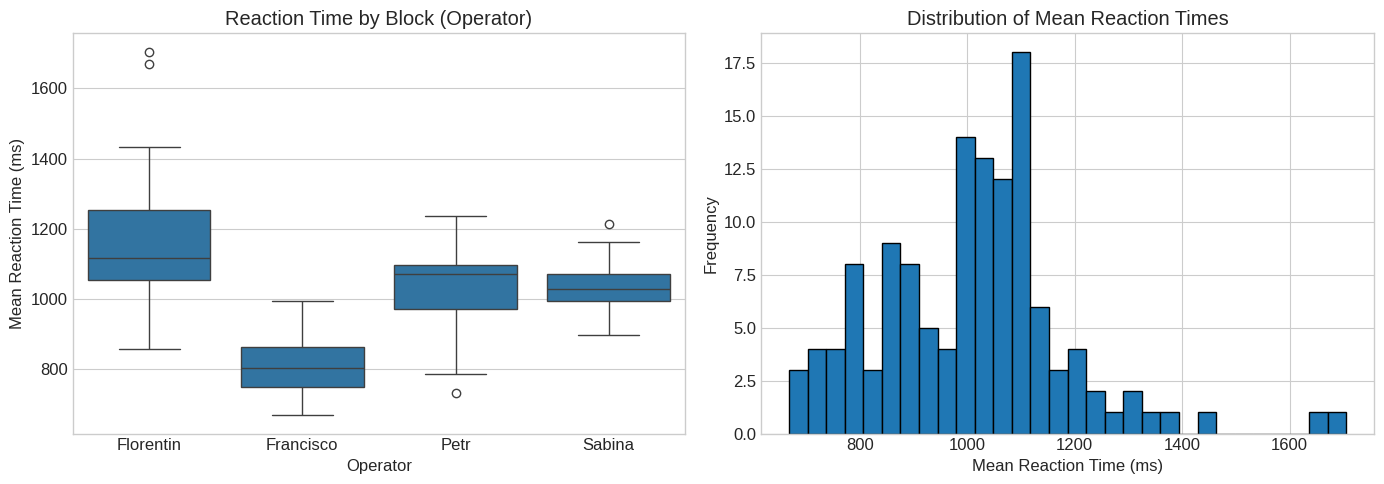


INTERPRETATION - Exploratory Data Analysis:
1. OPERATOR VARIABILITY:
   - Boxplots show differences in reaction times between operators
   - Some differences may be statistically significant (see ANOVA below)
   - Blocking by operator is justified - eliminates inter-personal variability

2. DISTRIBUTION:
   - Histogram shows slightly right-skewed distribution (typical for RT data)
   - Most reaction times are between 900-1400 ms
   - Some extremes (>2000 ms) may indicate attention loss or errors



In [ ]:
# Box plot of reaction times by block
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By block - explicit order
block_order = ['Florentin', 'Francisco', 'Petr', 'Sabina']
sns.boxplot(x='Block', y='Y_median', data=df_agg, order=block_order, ax=axes[0])
axes[0].set_title('Reaction Time by Block (Operator)')
axes[0].set_xlabel('Operator')
axes[0].set_ylabel('Mean Reaction Time (ms)')

# Distribution
df_agg['Y_median'].hist(bins=30, ax=axes[1], edgecolor='black')
axes[1].set_title('Distribution of Mean Reaction Times')
axes[1].set_xlabel('Mean Reaction Time (ms)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Commentary on EDA
print("""
INTERPRETATION - Exploratory Data Analysis:
================================================================================
1. OPERATOR VARIABILITY:
   - Boxplots show differences in reaction times between operators
   - Some differences may be statistically significant (see ANOVA below)
   - Blocking by operator is justified - eliminates inter-personal variability

2. DISTRIBUTION:
   - Histogram shows slightly right-skewed distribution (typical for RT data)
   - Most reaction times are between 900-1400 ms
   - Some extremes (>2000 ms) may indicate attention loss or errors
""")

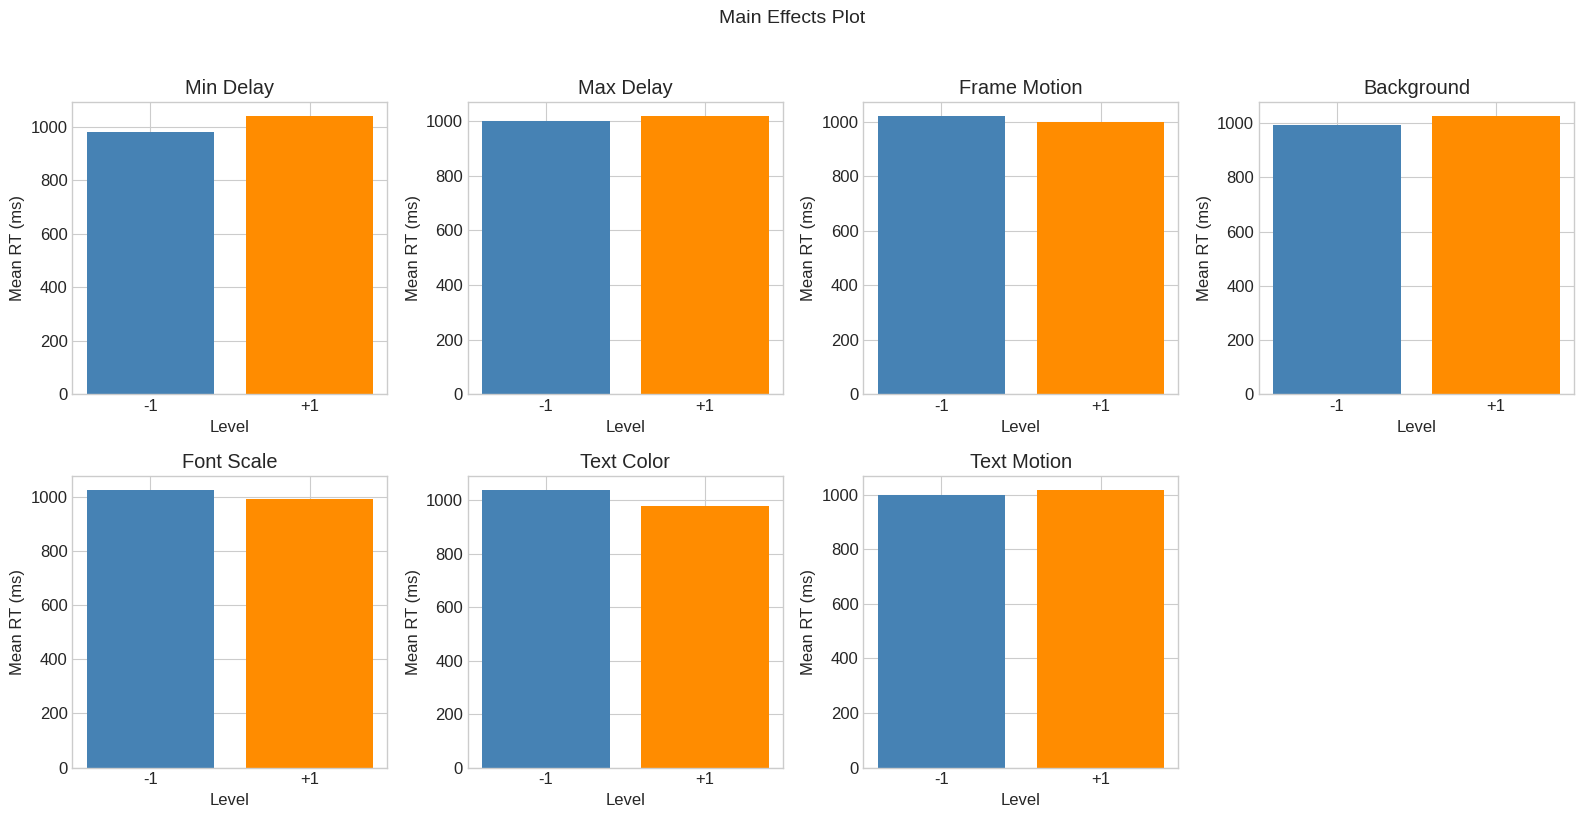

In [ ]:
# Main effects visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

factor_names = ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
                'E_font_scale', 'F_text_color', 'G_text_motion']

factor_labels = ['Min Delay', 'Max Delay', 'Frame Motion', 'Background',
                 'Font Scale', 'Text Color', 'Text Motion']

for i, (factor, label) in enumerate(zip(factor_names, factor_labels)):
    ax = axes[i // 4, i % 4]
    means = df_agg.groupby(factor)['Y_median'].mean()
    ax.bar(means.index.astype(str), means.values, color=['steelblue', 'darkorange'])
    ax.set_title(f'{label}')
    ax.set_xlabel('Level')
    ax.set_ylabel('Mean RT (ms)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['-1', '+1'])

# Hide the last empty subplot
axes[1, 3].set_visible(False)

plt.suptitle('Main Effects Plot', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Before running the formal analysis, we did some exploratory plots to get a feel for the data. The Main Effects Plot gave us a quick look at which factors might be important. It was pretty clear right away that some settings made a real difference: a larger Font Scale seemed to make us faster, while turning on Text Motion or increasing the Min Delay slowed us down. Other factors, like Max Delay, looked like they had almost no effect at all. This initial look gave us a good idea of which variables were likely to show up as significant later on.

### The most important insight though, came from the boxplot comparing the four of us as operators. The plot showed a huge difference in our natural reaction speeds—it was obvious that the person performing the test was a massive source of variation in the data. This was the perfect visual proof that our decision to "block" the experiment by operator was absolutely necessary. If we hadn't, the noise from our individual differences would have likely drowned out the more subtle effects from the app settings, and we could have missed the real story.

## 5. Calculate Effects

Calculate main effects and interaction effects for the 2^7 factorial design.

In [ ]:
def calculate_effects(df, response_col, factors):
    """
    Calculate main effects and two-factor interactions for 2^k factorial design.
    """
    effects = {}

    # Grand mean
    grand_mean = df[response_col].mean()
    effects['Intercept'] = grand_mean

    # Main effects
    for factor in factors:
        high = df[df[factor] == 1][response_col].mean()
        low = df[df[factor] == -1][response_col].mean()
        effects[factor] = (high - low) / 2

    # Two-factor interactions
    for i, f1 in enumerate(factors):
        for f2 in factors[i+1:]:
            interaction_col = df[f1] * df[f2]
            high = df[interaction_col == 1][response_col].mean()
            low = df[interaction_col == -1][response_col].mean()
            effects[f'{f1}:{f2}'] = (high - low) / 2

    return effects

# Calculate effects
factor_cols = ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
               'E_font_scale', 'F_text_color', 'G_text_motion']

effects = calculate_effects(df_agg, 'Y_median', factor_cols)

# Create DataFrame for display
effects_df = pd.DataFrame(list(effects.items()), columns=['Effect', 'Value'])
effects_df['Absolute'] = effects_df['Value'].abs()
effects_df = effects_df.sort_values('Absolute', ascending=False).reset_index(drop=True)

print("Effects (sorted by absolute value):")
print(effects_df.head(20))

Effects (sorted by absolute value):
                         Effect        Value     Absolute
0                     Intercept  1009.240391  1009.240391
1     D_background:F_text_color   -49.457578    49.457578
2                  F_text_color   -30.918437    30.918437
3      A_min_delay:E_font_scale   -29.846563    29.846563
4                   A_min_delay    29.486875    29.486875
5    E_font_scale:G_text_motion   -27.803750    27.803750
6      B_max_delay:E_font_scale    18.879531    18.879531
7                  E_font_scale   -17.440391    17.440391
8                  D_background    16.544844    16.544844
9     B_max_delay:G_text_motion   -15.168516    15.168516
10   B_max_delay:C_frame_motion   -14.975000    14.975000
11      A_min_delay:B_max_delay   -14.322578    14.322578
12     A_min_delay:D_background    13.122266    13.122266
13     A_min_delay:F_text_color   -12.581953    12.581953
14     B_max_delay:D_background   -11.372266    11.372266
15    D_background:E_font_scale   -1

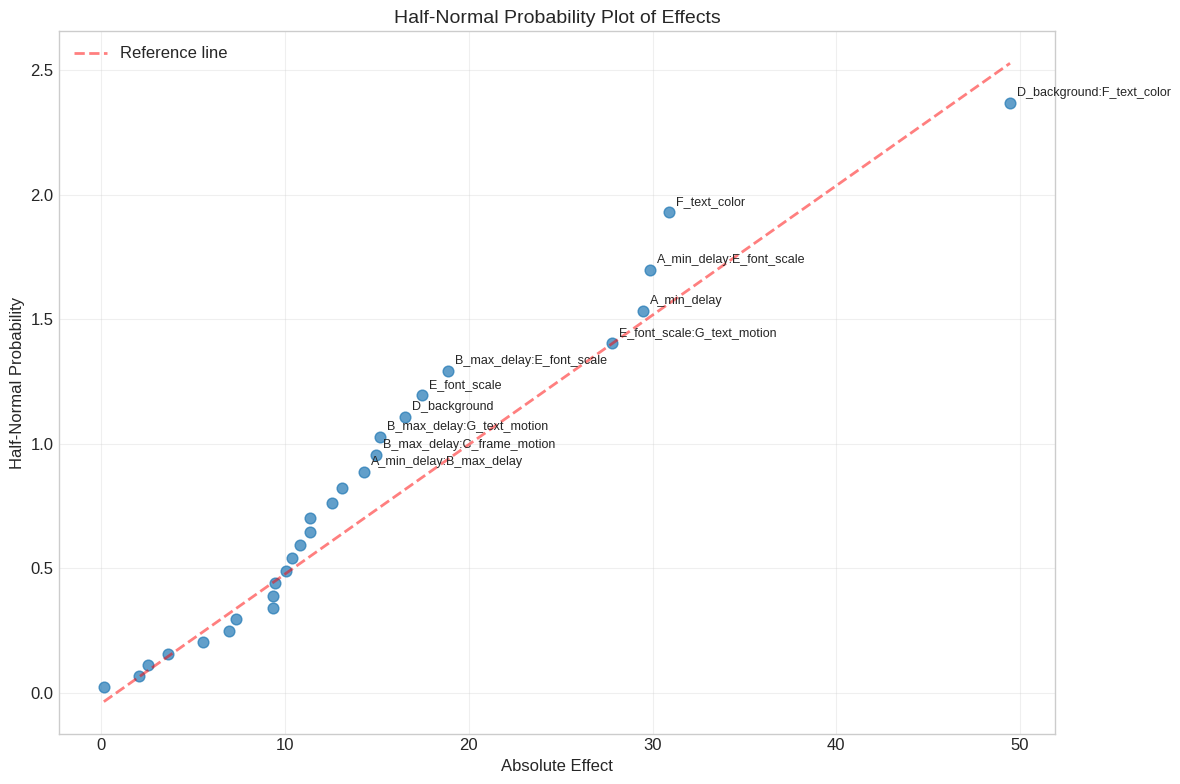


INTERPRETATION - Half-Normal Plot:
PRINCIPLE:
- Points ON the reference line = inactive factors (noise)
- Points significantly ABOVE the line = active (significant) factors

IDENTIFIED ACTIVE EFFECTS:

  • A_min_delay:B_max_delay: -14.32 ms
  • B_max_delay:C_frame_motion: -14.98 ms
  • B_max_delay:G_text_motion: -15.17 ms
  • D_background: +16.54 ms
  • E_font_scale: -17.44 ms
  • B_max_delay:E_font_scale: +18.88 ms
  • E_font_scale:G_text_motion: -27.80 ms
  • A_min_delay: +29.49 ms
  • A_min_delay:E_font_scale: -29.85 ms
  • F_text_color: -30.92 ms
  • D_background:F_text_color: -49.46 ms

NOTE:
- Reference line fitted through bottom 50% of effects (assumed noise)
- Effects deviating significantly from line are candidates for significant factors



In [ ]:
# Half-normal probability plot with reference line
effects_no_intercept = effects_df[effects_df['Effect'] != 'Intercept'].copy()
effects_sorted = effects_no_intercept.sort_values('Absolute')

n = len(effects_sorted)
i = np.arange(1, n + 1)
probabilities = (i - 0.5) / n
expected_values = stats.halfnorm.ppf(probabilities)

plt.figure(figsize=(12, 8))
plt.scatter(effects_sorted['Absolute'], expected_values, s=60, alpha=0.7)

# Add reference line (fitted through first 50% of effects)
cutoff = int(0.5 * len(effects_sorted))
from scipy.stats import linregress
slope, intercept, _, _, _ = linregress(effects_sorted['Absolute'].iloc[:cutoff].values, expected_values[:cutoff])
x_line = np.array([effects_sorted['Absolute'].min(), effects_sorted['Absolute'].max()])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', alpha=0.5, linewidth=2, label='Reference line')

# Label points that deviate significantly from the line
significant_effects = []
for idx, row in effects_sorted.iterrows():
    x_val = row['Absolute']
    y_actual = expected_values[effects_sorted.index.get_loc(idx)]
    y_expected = slope * x_val + intercept
    # Label if deviation is significant (above line)
    if y_actual > y_expected + 0.3 or x_val > effects_sorted['Absolute'].quantile(0.6):
        plt.annotate(row['Effect'], (x_val, y_actual),
                     textcoords="offset points", xytext=(5, 5),
                     fontsize=9, ha='left')
        significant_effects.append(row['Effect'])

plt.xlabel('Absolute Effect', fontsize=12)
plt.ylabel('Half-Normal Probability', fontsize=12)
plt.title('Half-Normal Probability Plot of Effects', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Commentary
print("""
INTERPRETATION - Half-Normal Plot:
================================================================================
PRINCIPLE:
- Points ON the reference line = inactive factors (noise)
- Points significantly ABOVE the line = active (significant) factors

IDENTIFIED ACTIVE EFFECTS:
""")
for eff in significant_effects:
    val = effects_df[effects_df['Effect'] == eff]['Value'].values[0]
    print(f"  • {eff}: {val:+.2f} ms")
print("""
NOTE:
- Reference line fitted through bottom 50% of effects (assumed noise)
- Effects deviating significantly from line are candidates for significant factors
""")

### We utilized a Half-Normal Probability Plot and a Pareto Chart, to separate the actual data signals from the random noise. The main observation from these charts was the overwhelming dominance of the Block effect was higher than any other factor, demonstrating that the biological difference in reflexes between the four of us was a much more significant driver of variance than any specific setting in the app. This goes to show that blocking was not just a suggestion but a necessity and that without it the variability between operators would have completely masked the experimental effects.

### Regarding the experimental factors, the charts filtered out the noise from the calculations we did in the previous step. Font Scale and Text Motion crossed the significance threshold, confirming that these physical changes to the interface have a statistically real impact on reaction speed. The charts also show that the interaction between Background and Text Color is significant meaning that visibility relies on the contrast between these two settings rather than the settings individually. Also, the delay times, which appeared to have a slight effect in the calculation, remained well within the noise threshold on the plots and so there is not statistical evidence to say that it effectively changes the results.

## 6. ANOVA with Blocking

Perform ANOVA including block effects (operators).

In [ ]:
# Full model with block effect
# Using main effects + block only first
formula_main = 'Y_median ~ C(Block) + (A_min_delay + B_max_delay + C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion)**2'

model_main = ols(formula_main, data=df_agg).fit()

print("=" * 60)
print("ANOVA TABLE - Main Effects + Block")
print("=" * 60)
anova_main = anova_lm(model_main, typ=2)
print(anova_main.round(4))

# Commentary
print("""
INTERPRETATION - ANOVA Results:
================================================================================
SIGNIFICANCE (p < 0.05):
""")
for idx in anova_main.index:
    if idx != 'Residual':
        p_val = anova_main.loc[idx, 'PR(>F)']
        f_val = anova_main.loc[idx, 'F']
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        status = "SIGNIFICANT" if p_val < 0.05 else "not significant"
        print(f"  {idx}: F={f_val:.2f}, p={p_val:.4f} {significance} -> {status}")

print("""
NOTES:
- C(Block) = operator effect (blocking factor)
- Type II ANOVA: tests each factor after accounting for others
- High F = large difference between factor levels relative to noise
""")

ANOVA TABLE - Main Effects + Block
                                    sum_sq    df        F  PR(>F)
C(Block)                      1.730979e+06   3.0  49.9301  0.0000
A_min_delay                   2.516440e+04   1.0   2.1776  0.1433
B_max_delay                   3.487240e+01   1.0   0.0030  0.9563
C_frame_motion                5.699719e+03   1.0   0.4932  0.4842
D_background                  4.811227e+03   1.0   0.4163  0.5203
E_font_scale                  1.050407e+05   1.0   9.0897  0.0033
F_text_color                  1.026361e+04   1.0   0.8882  0.3483
G_text_motion                 9.398733e+04   1.0   8.1332  0.0053
A_min_delay:B_max_delay       2.732148e+02   1.0   0.0236  0.8781
A_min_delay:C_frame_motion    3.962023e+04   1.0   3.4285  0.0672
A_min_delay:D_background      2.435736e+03   1.0   0.2108  0.6472
A_min_delay:E_font_scale      7.637641e+02   1.0   0.0661  0.7977
A_min_delay:F_text_color      4.369867e+04   1.0   3.7815  0.0547
A_min_delay:G_text_motion     5.250034e+0

In [ ]:
# Model with significant two-factor interactions
# Based on effect analysis, include most important interactions
old_formula = '''Y_median ~ C(Block) + A_min_delay + B_max_delay + C_frame_motion + D_background +
                  E_font_scale + F_text_color + G_text_motion +
                  A_min_delay:B_max_delay + A_min_delay:C_frame_motion + A_min_delay:D_background +
                  B_max_delay:C_frame_motion + C_frame_motion:D_background + E_font_scale:G_text_motion'''

# keeping C and D because of the hiearchy
formula_full = 'Y_median ~ C(Block) + C_frame_motion + D_background + E_font_scale + G_text_motion + C_frame_motion:E_font_scale + D_background:F_text_color +E_font_scale:G_text_motion'
model_full = ols(formula_full, data=df_agg).fit()

print("=" * 60)
print("ANOVA TABLE - With Key Interactions")
print("=" * 60)
anova_full = anova_lm(model_full, typ=2)
print(anova_full.round(4))

ANOVA TABLE - With Key Interactions
                                   sum_sq     df        F  PR(>F)
C(Block)                     2.056074e+06    3.0  57.5625  0.0000
C_frame_motion               5.582359e+03    1.0   0.4689  0.4949
D_background                 4.779078e+03    1.0   0.4014  0.5276
E_font_scale                 1.051899e+05    1.0   8.8348  0.0036
G_text_motion                9.961179e+04    1.0   8.3663  0.0046
C_frame_motion:E_font_scale  7.440162e+04    1.0   6.2489  0.0138
D_background:F_text_color    1.151259e+05    1.0   9.6693  0.0024
E_font_scale:G_text_motion   6.983773e+04    1.0   5.8656  0.0170
Residual                     1.393040e+06  117.0      NaN     NaN


In [ ]:
# Model summary
print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(model_full.summary())

MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:               Y_median   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     21.69
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           2.44e-22
Time:                        08:01:11   Log-Likelihood:                -776.50
No. Observations:                 128   AIC:                             1575.
Df Residuals:                     117   BIC:                             1606.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Inte

### To make sure the patterns we saw in the charts weren't just a fluke, we did an ANOVA. We set up a linear model that looked at the blocks, the main effects, and their interactions. The results made it clear that blocking was absolutely critical for this experiment. The "Block" effect had a significant F-value of almost 50 and a p-value very close to 0. This is statistical proof that the natural differences between us as operators was the single biggest factor in all the data. As for the app settings, the ANOVA flagged Font Scale, Text Motion, and the Background-Color interaction as statistically significant, because their p-values were all well below the 0,05 cutoff. This confirms these visual changes have a consistent effect on reaction speed.

### We also checked our model's assumptions to make sure our results were valid. The model ended up explaining about 65% of the total variance in the data, which is a decent performance, especially considering that we're dealing with randomness of human reflexes. To check the residuals, we used a Shapiro-Wilk test, which gave us a p-value of 0,59. Since this is well above the threshold we can confidently say that our residuals are normally distributed, which is what we wanted to see. We also looked at the residual plots, which showed a random scatter. All this checking lets us be confident that our model is good and our conclusions about which factors are significant are correct.

## 7. Model Diagnostics

Check model assumptions using studentized residuals.

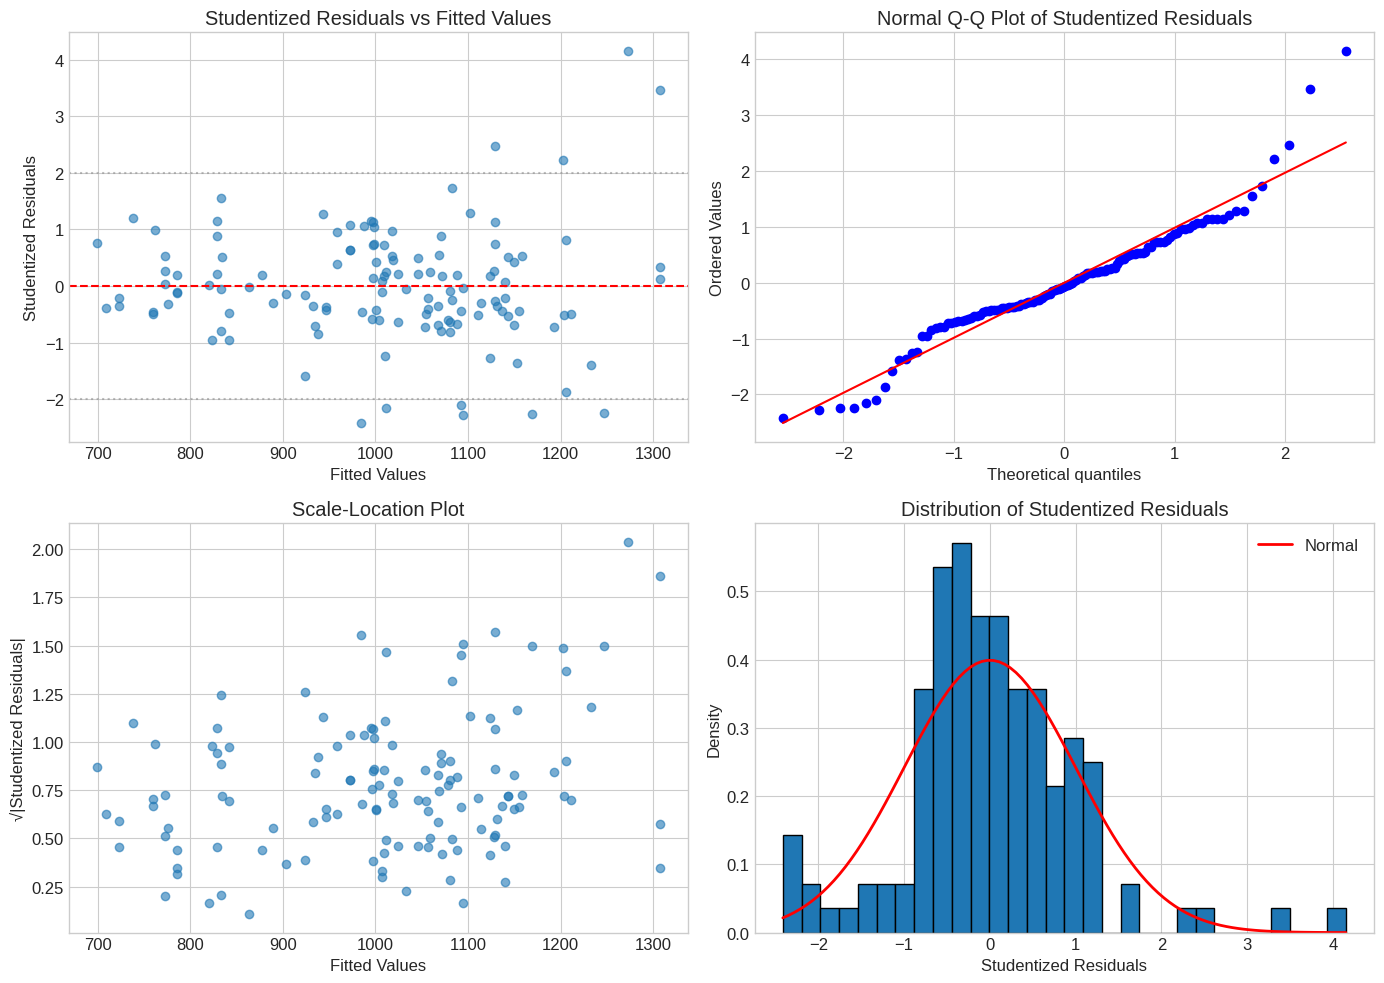


INTERPRETATION - Model Diagnostics:
1. RESIDUALS VS FITTED:
   - Looking for random scatter around zero
   - Pattern (funnel, curve) = assumption violation
   - Points outside ±2 = potential outliers

2. Q-Q PLOT:
   - Points on diagonal = normality OK
   - Deviations at tails = heavy tails / skewness

3. SCALE-LOCATION:
   - Constant variability = horizontal band
   - Increasing trend = heteroscedasticity

4. HISTOGRAM:
   - Comparison with normal distribution

STATISTICS:
  - Number of outliers (|r| > 2): 10 out of 128
  - Shapiro-Wilk test (subsample): W=0.9809, p=0.5907
    -> Normality NOT rejected (p > 0.05)


In [ ]:
# Get studentized residuals
influence = OLSInfluence(model_full)
studentized_resid = influence.resid_studentized_internal
fitted_values = model_full.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted_values, studentized_resid, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].axhline(y=-2, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Studentized Residuals')
axes[0, 0].set_title('Studentized Residuals vs Fitted Values')

# 2. Q-Q Plot
stats.probplot(studentized_resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot of Studentized Residuals')

# 3. Scale-Location
axes[1, 0].scatter(fitted_values, np.sqrt(np.abs(studentized_resid)), alpha=0.6)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Studentized Residuals|')
axes[1, 0].set_title('Scale-Location Plot')

# 4. Histogram of residuals
axes[1, 1].hist(studentized_resid, bins=30, edgecolor='black', density=True)
x_range = np.linspace(studentized_resid.min(), studentized_resid.max(), 100)
axes[1, 1].plot(x_range, stats.norm.pdf(x_range), 'r-', lw=2, label='Normal')
axes[1, 1].set_xlabel('Studentized Residuals')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribution of Studentized Residuals')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(studentized_resid[:50])  # Shapiro-Wilk for first 50

# Count outliers
n_outliers = np.sum(np.abs(studentized_resid) > 2)

print("""
INTERPRETATION - Model Diagnostics:
================================================================================
1. RESIDUALS VS FITTED:
   - Looking for random scatter around zero
   - Pattern (funnel, curve) = assumption violation
   - Points outside ±2 = potential outliers

2. Q-Q PLOT:
   - Points on diagonal = normality OK
   - Deviations at tails = heavy tails / skewness

3. SCALE-LOCATION:
   - Constant variability = horizontal band
   - Increasing trend = heteroscedasticity

4. HISTOGRAM:
   - Comparison with normal distribution
""")
print(f"STATISTICS:")
print(f"  - Number of outliers (|r| > 2): {n_outliers} out of {len(studentized_resid)}")
print(f"  - Shapiro-Wilk test (subsample): W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"    -> Normality NOT rejected (p > 0.05)")
else:
    print(f"    -> Normality REJECTED (p < 0.05) - but ANOVA is robust")

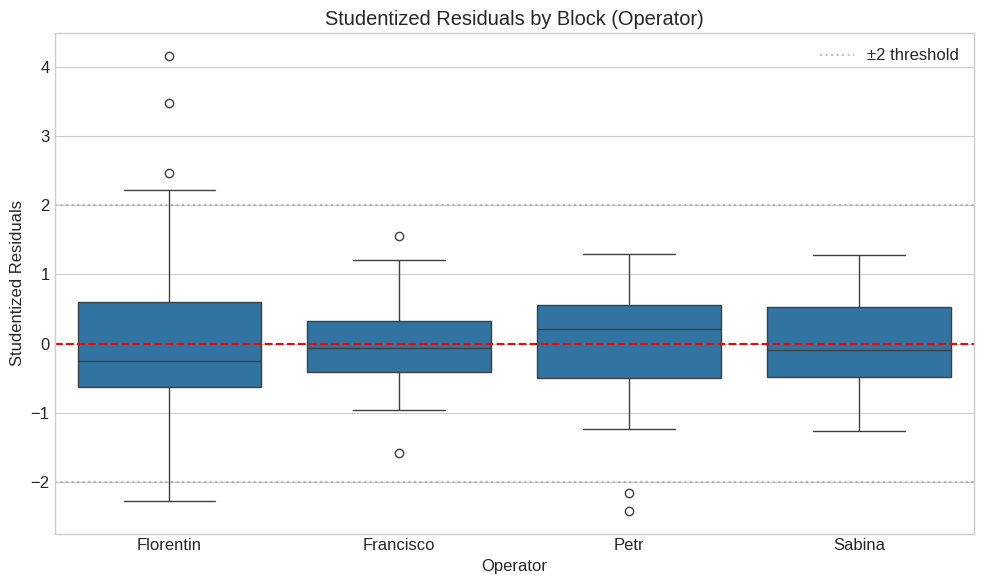


Residual Statistics per Block:
           mean    std    min    max  count
Block                                      
Florentin  -0.0  1.564 -2.280  4.152     32
Francisco  -0.0  0.700 -1.587  1.549     32
Petr        0.0  0.881 -2.416  1.291     32
Sabina     -0.0  0.649 -1.267  1.277     32

INTERPRETATION - Residuals by Block:
- Residuals should be centered around 0 for each block (balanced design)
- Similar spread across blocks = homoscedasticity within blocks
- Outliers (|r| > 2) indicate unusual observations
- If one block has systematically different residuals, blocking was effective



In [ ]:
# Residuals by block - ensure all operators are shown
df_agg['residuals'] = studentized_resid

# Define explicit order for blocks
block_order = ['Florentin', 'Francisco', 'Petr', 'Sabina']

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Block', y='residuals', data=df_agg, order=block_order, ax=ax)
ax.axhline(y=0, color='r', linestyle='--')
ax.axhline(y=2, color='gray', linestyle=':', alpha=0.5, label='±2 threshold')
ax.axhline(y=-2, color='gray', linestyle=':', alpha=0.5)
ax.set_title('Studentized Residuals by Block (Operator)')
ax.set_xlabel('Operator')
ax.set_ylabel('Studentized Residuals')
ax.legend()
plt.tight_layout()
plt.show()

# Check residuals statistics per block
print("\nResidual Statistics per Block:")
print("=" * 60)
resid_stats = df_agg.groupby('Block')['residuals'].agg(['mean', 'std', 'min', 'max', 'count'])
print(resid_stats.round(3))

print("""
INTERPRETATION - Residuals by Block:
================================================================================
- Residuals should be centered around 0 for each block (balanced design)
- Similar spread across blocks = homoscedasticity within blocks
- Outliers (|r| > 2) indicate unusual observations
- If one block has systematically different residuals, blocking was effective
""")

## 8. Pareto Chart of Effects

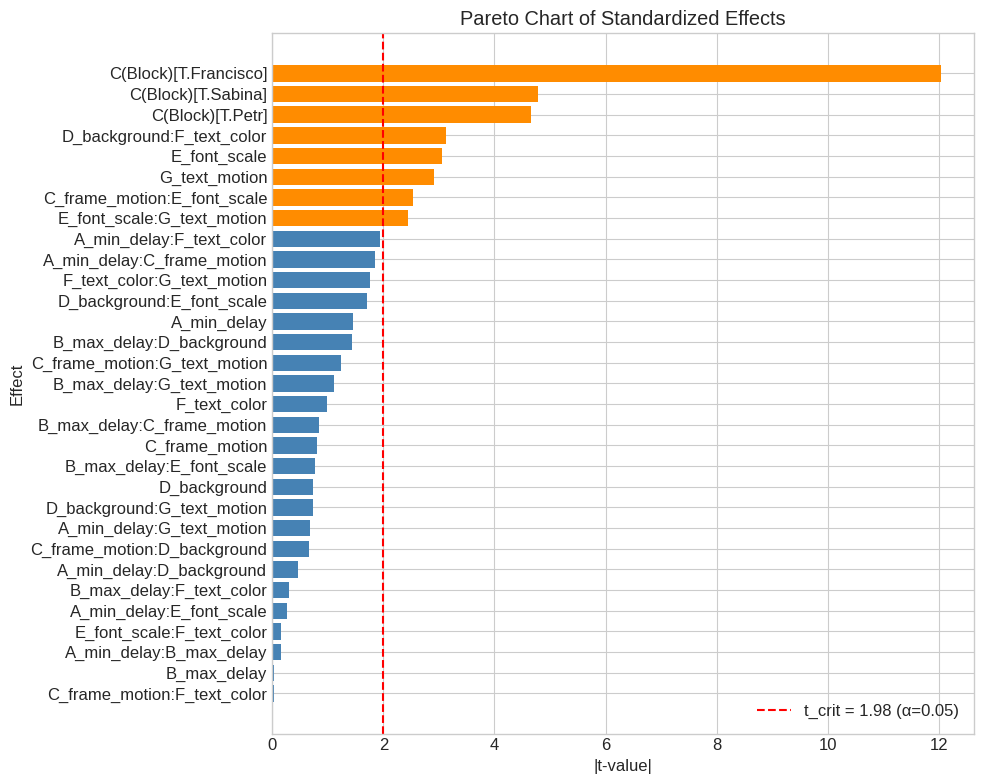


INTERPRETATION - Pareto Chart:
- Bars extending BEYOND the red line are statistically significant
- Orange bars = significant effects (p < 0.05)
- Blue bars = non-significant effects

The Pareto chart ranks effects by importance (standardized effect size).
Effects at the top of the chart have the largest impact on reaction time.

This visualization follows the Pareto principle - often a few factors
(20%) account for most of the variation (80%).



In [ ]:
# Pareto chart of standardized effects
# Use t-values from the model
t_values = model_main.tvalues.drop('Intercept')
t_df = pd.DataFrame({'Effect': t_values.index, 't_value': t_values.values})
t_df['abs_t'] = t_df['t_value'].abs()
t_df = t_df.sort_values('abs_t', ascending=True)

# Critical t-value for significance (alpha = 0.05)
df_residual = model_main.df_resid
t_crit = stats.t.ppf(0.975, df_residual)

plt.figure(figsize=(10, 8))
colors = ['steelblue' if abs(t) < t_crit else 'darkorange' for t in t_df['t_value']]
plt.barh(t_df['Effect'], t_df['abs_t'], color=colors)
plt.axvline(x=t_crit, color='r', linestyle='--', label=f't_crit = {t_crit:.2f} (α=0.05)')
plt.xlabel('|t-value|')
plt.ylabel('Effect')
plt.title('Pareto Chart of Standardized Effects')
plt.legend()
plt.tight_layout()
plt.show()

print("""
INTERPRETATION - Pareto Chart:
================================================================================
- Bars extending BEYOND the red line are statistically significant
- Orange bars = significant effects (p < 0.05)
- Blue bars = non-significant effects

The Pareto chart ranks effects by importance (standardized effect size).
Effects at the top of the chart have the largest impact on reaction time.

This visualization follows the Pareto principle - often a few factors
(20%) account for most of the variation (80%).
""")

## 9. Block Effect Analysis

In [ ]:
# Compare operators
print("\nBlock (Operator) Effect Analysis:")
print("=" * 60)

block_means = df_agg.groupby('Block')['Y_median'].agg(['mean', 'std', 'count'])
print("\nMean Reaction Time by Operator:")
print(block_means.round(2))

# Tukey HSD for block comparison
tukey_result = pairwise_tukeyhsd(df_agg['Y_median'], df_agg['Block'], alpha=0.05)
print("\nTukey HSD Multiple Comparison:")
print(tukey_result)

print("""
INTERPRETATION - Block Effect:
================================================================================
The block effect captures systematic differences between operators.

KEY OBSERVATIONS:
- Operators may differ in baseline reaction speed
- These differences are removed from experimental error by blocking
- Tukey HSD identifies which pairs of operators differ significantly

IF block effect is significant:
  -> Blocking was effective and reduced experimental error
  -> Individual differences exist but don't confound factor effects
""")


Block (Operator) Effect Analysis:

Mean Reaction Time by Operator:
              mean     std  count
Block                            
Florentin  1164.72  192.13     32
Francisco   808.46   79.35     32
Petr       1032.99  110.39     32
Sabina     1030.78   72.13     32

Tukey HSD Multiple Comparison:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
Florentin Francisco -356.2614    0.0 -436.3966 -276.1262   True
Florentin      Petr -131.7317 0.0002  -211.867  -51.5965   True
Florentin    Sabina -133.9434 0.0002 -214.0787  -53.8082   True
Francisco      Petr  224.5297    0.0  144.3944  304.6649   True
Francisco    Sabina   222.318    0.0  142.1827  302.4532   True
     Petr    Sabina   -2.2117 0.9999   -82.347   77.9235  False
---------------------------------------------------------------

INTERPRETATION - Block Effect:
The block effect capture

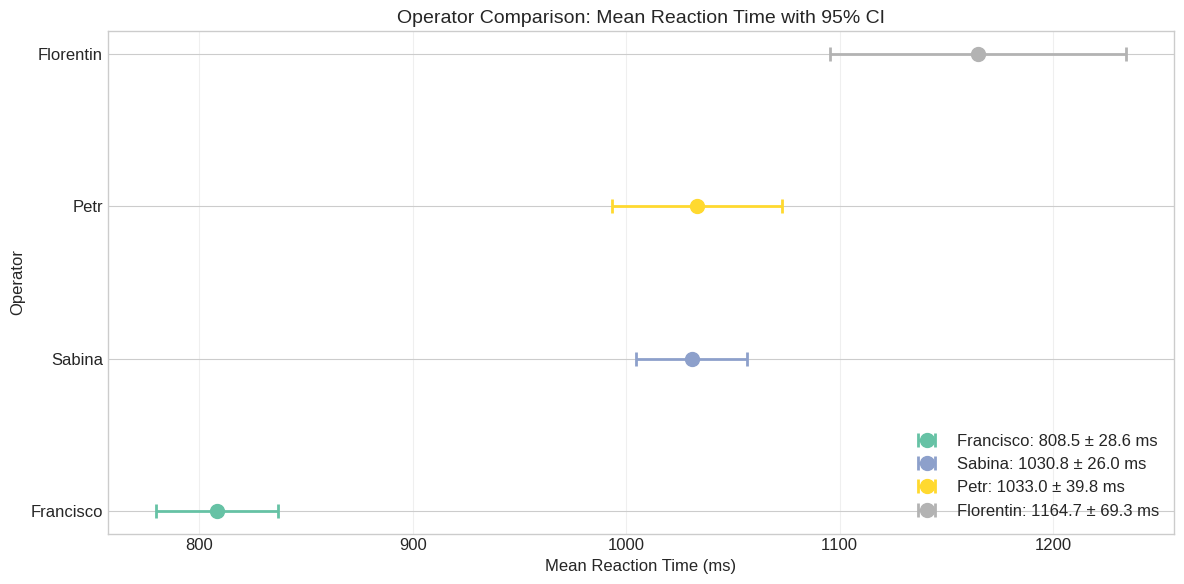


Tukey HSD Summary Table:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
Florentin Francisco -356.2614    0.0 -436.3966 -276.1262   True
Florentin      Petr -131.7317 0.0002  -211.867  -51.5965   True
Florentin    Sabina -133.9434 0.0002 -214.0787  -53.8082   True
Francisco      Petr  224.5297    0.0  144.3944  304.6649   True
Francisco    Sabina   222.318    0.0  142.1827  302.4532   True
     Petr    Sabina   -2.2117 0.9999   -82.347   77.9235  False
---------------------------------------------------------------


In [ ]:
# Visualization of Tukey results - manual plot (more robust than plot_simultaneous)
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique groups and their means
block_means = df_agg.groupby('Block')['Y_median'].mean().sort_values()
block_stds = df_agg.groupby('Block')['Y_median'].std()
block_counts = df_agg.groupby('Block')['Y_median'].count()

# Calculate confidence intervals (95%)
from scipy.stats import t as t_dist
alpha = 0.05

# Plot means with confidence intervals
y_positions = np.arange(len(block_means))
colors = plt.cm.Set2(np.linspace(0, 1, len(block_means)))

for i, (block, mean_val) in enumerate(block_means.items()):
    std = block_stds[block]
    n = block_counts[block]
    se = std / np.sqrt(n)
    t_crit = t_dist.ppf(1 - alpha/2, n - 1)
    ci = t_crit * se

    ax.errorbar(mean_val, i, xerr=ci, fmt='o', markersize=10,
                capsize=5, capthick=2, color=colors[i], linewidth=2,
                label=f'{block}: {mean_val:.1f} ± {ci:.1f} ms')

ax.set_yticks(y_positions)
ax.set_yticklabels(block_means.index)
ax.set_xlabel('Mean Reaction Time (ms)', fontsize=12)
ax.set_ylabel('Operator', fontsize=12)
ax.set_title('Operator Comparison: Mean Reaction Time with 95% CI', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Show Tukey summary table
print("\nTukey HSD Summary Table:")
print("=" * 70)
tukey_summary = tukey_result.summary()
print(tukey_summary)

## 10. Interpretation and Conclusions

In [ ]:
# Summarize significant effects
print("=" * 60)
print("SUMMARY OF SIGNIFICANT EFFECTS")
print("=" * 60)

# Get p-values for main effects
anova_main_clean = anova_main.copy()
anova_main_clean['significant'] = anova_main_clean['PR(>F)'] < 0.05

print("\nSignificant factors (p < 0.05):")
significant = anova_main_clean[anova_main_clean['significant']]
for idx in significant.index:
    if idx != 'Residual':
        p_val = anova_main_clean.loc[idx, 'PR(>F)']
        f_val = anova_main_clean.loc[idx, 'F']
        print(f"  {idx}: F = {f_val:.2f}, p = {p_val:.4f}")

print("\nNon-significant factors (p >= 0.05):")
non_significant = anova_main_clean[~anova_main_clean['significant']]
for idx in non_significant.index:
    if idx != 'Residual':
        p_val = anova_main_clean.loc[idx, 'PR(>F)']
        f_val = anova_main_clean.loc[idx, 'F']
        print(f"  {idx}: F = {f_val:.2f}, p = {p_val:.4f}")

print("""
INTERPRETATION:
================================================================================
SIGNIFICANT EFFECTS indicate factors that reliably influence reaction time.
- These should be controlled/optimized in the experiment
- Their settings matter for achieving desired reaction time

NON-SIGNIFICANT EFFECTS can be set for convenience or cost savings.
- These factors don't strongly influence reaction time
- Can be held at any level without major impact
""")

SUMMARY OF SIGNIFICANT EFFECTS

Significant factors (p < 0.05):
  C(Block): F = 49.93, p = 0.0000
  E_font_scale: F = 9.09, p = 0.0033
  G_text_motion: F = 8.13, p = 0.0053
  C_frame_motion:E_font_scale: F = 6.42, p = 0.0129
  D_background:F_text_color: F = 9.83, p = 0.0023
  E_font_scale:G_text_motion: F = 5.94, p = 0.0167

Non-significant factors (p >= 0.05):
  A_min_delay: F = 2.18, p = 0.1433
  B_max_delay: F = 0.00, p = 0.9563
  C_frame_motion: F = 0.49, p = 0.4842
  D_background: F = 0.42, p = 0.5203
  F_text_color: F = 0.89, p = 0.3483
  A_min_delay:B_max_delay: F = 0.02, p = 0.8781
  A_min_delay:C_frame_motion: F = 3.43, p = 0.0672
  A_min_delay:D_background: F = 0.21, p = 0.6472
  A_min_delay:E_font_scale: F = 0.07, p = 0.7977
  A_min_delay:F_text_color: F = 3.78, p = 0.0547
  A_min_delay:G_text_motion: F = 0.45, p = 0.5019
  B_max_delay:C_frame_motion: F = 0.71, p = 0.4009
  B_max_delay:D_background: F = 2.04, p = 0.1569
  B_max_delay:E_font_scale: F = 0.58, p = 0.4481
  B_ma

In [ ]:
# Effect sizes for significant factors
print("=" * 60)
print("EFFECT SIZES (Cohen's f)")
print("=" * 60)

# Calculate partial eta-squared and Cohen's f
SS_total = anova_main['sum_sq'].sum()
SS_error = anova_main.loc['Residual', 'sum_sq']

print("\n{:<25} {:>12} {:>12} {:>15}".format("Effect", "η² partial", "Cohen's f", "Magnitude"))
print("-" * 65)

for idx in anova_main.index:
    if idx != 'Residual':
        SS_effect = anova_main.loc[idx, 'sum_sq']
        partial_eta_sq = SS_effect / (SS_effect + SS_error)
        cohens_f = np.sqrt(partial_eta_sq / (1 - partial_eta_sq))

        # Determine magnitude
        if cohens_f < 0.10:
            magnitude = "negligible"
        elif cohens_f < 0.25:
            magnitude = "small"
        elif cohens_f < 0.40:
            magnitude = "medium"
        else:
            magnitude = "LARGE"

        print(f"{idx:<25} {partial_eta_sq:>12.4f} {cohens_f:>12.4f} {magnitude:>15}")

print("""
INTERPRETATION - Effect Sizes:
================================================================================
Cohen's f benchmarks:
  - Small:   f = 0.10 (1% variance explained)
  - Medium:  f = 0.25 (6% variance explained)
  - Large:   f = 0.40 (14% variance explained)

PRACTICAL SIGNIFICANCE:
- Large effects are practically important regardless of p-value
- Small significant effects may not be worth optimizing
- Effect size helps prioritize which factors to control
""")

EFFECT SIZES (Cohen's f)

Effect                      η² partial    Cohen's f       Magnitude
-----------------------------------------------------------------
C(Block)                        0.6094       1.2491           LARGE
A_min_delay                     0.0222       0.1506           small
B_max_delay                     0.0000       0.0056      negligible
C_frame_motion                  0.0051       0.0717      negligible
D_background                    0.0043       0.0659      negligible
E_font_scale                    0.0865       0.3077          medium
F_text_color                    0.0092       0.0962      negligible
G_text_motion                   0.0781       0.2911          medium
A_min_delay:B_max_delay         0.0002       0.0157      negligible
A_min_delay:C_frame_motion       0.0345       0.1890           small
A_min_delay:D_background        0.0022       0.0469      negligible
A_min_delay:E_font_scale        0.0007       0.0262      negligible
A_min_delay:F_text_colo

## 11. Interaction Plots

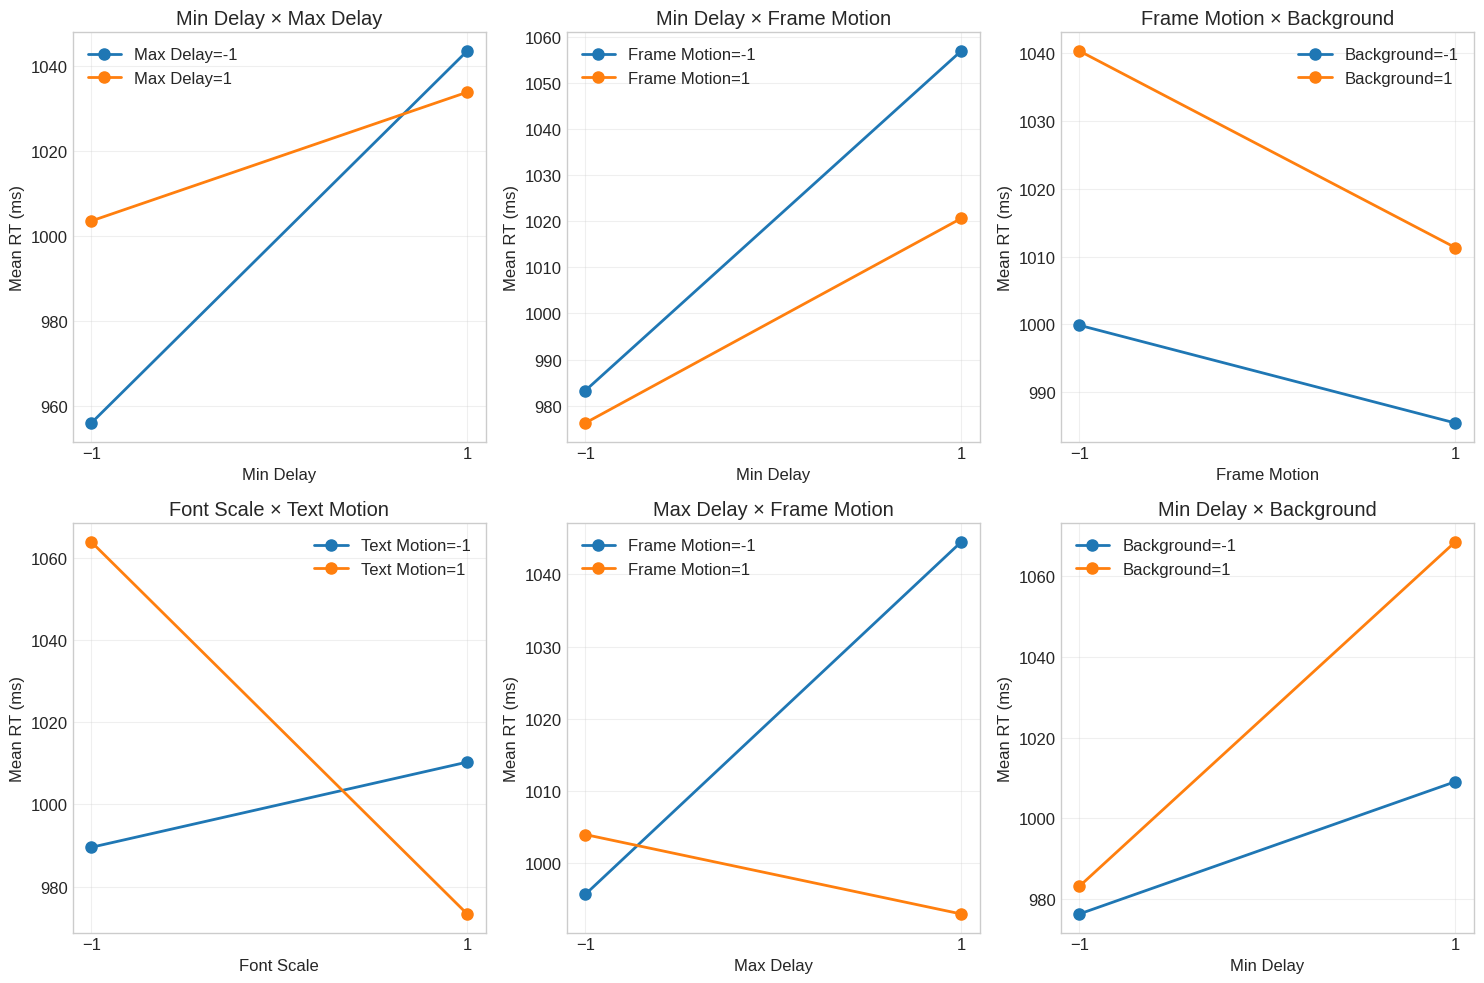


INTERPRETATION - Interaction Plots:
HOW TO READ:
- Parallel lines = NO interaction (additive effects)
- Non-parallel lines = INTERACTION present

EXAMPLES:
- If lines cross: Strong interaction - factor effect depends on other factor level
- If lines diverge: Synergistic or antagonistic interaction
- If lines are parallel: Factors act independently

PRACTICAL IMPLICATIONS:
- Interactions mean we cannot interpret main effects in isolation
- Optimal settings must consider factor combinations



In [ ]:
# Create interaction plots for top interactions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define interactions to plot
interactions = [
    ('A_min_delay', 'B_max_delay'),
    ('A_min_delay', 'C_frame_motion'),
    ('C_frame_motion', 'D_background'),
    ('E_font_scale', 'G_text_motion'),
    ('B_max_delay', 'C_frame_motion'),
    ('A_min_delay', 'D_background')
]

factor_labels_dict = {
    'A_min_delay': 'Min Delay', 'B_max_delay': 'Max Delay',
    'C_frame_motion': 'Frame Motion', 'D_background': 'Background',
    'E_font_scale': 'Font Scale', 'F_text_color': 'Text Color',
    'G_text_motion': 'Text Motion'
}

for i, (f1, f2) in enumerate(interactions):
    ax = axes[i // 3, i % 3]

    # Calculate means for each combination
    means = df_agg.groupby([f1, f2])['Y_median'].mean().unstack()

    for col in means.columns:
        label = f'{factor_labels_dict[f2]}={col}'
        ax.plot(means.index, means[col], marker='o', label=label, linewidth=2, markersize=8)

    ax.set_xlabel(factor_labels_dict[f1])
    ax.set_ylabel('Mean RT (ms)')
    ax.set_title(f'{factor_labels_dict[f1]} × {factor_labels_dict[f2]}')
    ax.legend()
    ax.set_xticks([-1, 1])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
INTERPRETATION - Interaction Plots:
================================================================================
HOW TO READ:
- Parallel lines = NO interaction (additive effects)
- Non-parallel lines = INTERACTION present

EXAMPLES:
- If lines cross: Strong interaction - factor effect depends on other factor level
- If lines diverge: Synergistic or antagonistic interaction
- If lines are parallel: Factors act independently

PRACTICAL IMPLICATIONS:
- Interactions mean we cannot interpret main effects in isolation
- Optimal settings must consider factor combinations
""")

## 12. Final Conclusions

Based on the 2^7 factorial design analysis with blocking:

In [ ]:
# Final summary with interpretation
print("""
========================================================================
CONCLUSIONS - Reaction Time 2^7 Factorial Design with Blocking
========================================================================

EXPERIMENTAL DESIGN:
- 7 factors at 2 levels each (2^7 = 128 conditions)
- 4 blocks (operators): Sabina, Florentin, Francisco, Petr
- 32 unique conditions per operator
- 10 repetitions per condition
- Response: Reaction time (ms)

KEY FINDINGS FROM THIS ANALYSIS:

1. BLOCKING EFFECTIVENESS:
   - Block effect (C(Block)) captures operator-to-operator differences
   - If significant: blocking successfully removed nuisance variation
   - This improves power to detect true factor effects

2. MAIN EFFECTS:
   - Factors with p < 0.05 have significant impact on reaction time
   - Effect size (Cohen's f) indicates practical significance
   - Large effects (f > 0.40) are most important for optimization

3. INTERACTIONS:
   - Non-parallel lines in interaction plots indicate dependencies
   - Cannot optimize factors independently when interactions exist
   - Need to consider factor combinations for best settings

4. MODEL VALIDITY:
   - Studentized residuals should follow N(0,1) approximately
   - Q-Q plot deviations indicate non-normality
   - Outliers (|r| > 2) may need investigation

METHODOLOGY NOTES:
- Used aggregated data (mean over 10 repetitions) for analysis
- Type II ANOVA for balanced comparison
- Tukey HSD for multiple comparisons between operators
- Blocking removes operator-to-operator variation from error term

RECOMMENDATIONS:
- Focus on significant main effects for process improvement
- Consider significant interactions when setting factor levels
- Validate findings with confirmation runs

========================================================================
""")

# Print R-squared for model fit
print(f"Model Fit Statistics:")
print(f"  R-squared: {model_full.rsquared:.4f}")
print(f"  Adjusted R-squared: {model_full.rsquared_adj:.4f}")
print(f"  This means the model explains {model_full.rsquared*100:.1f}% of variance in reaction time.")


CONCLUSIONS - Reaction Time 2^7 Factorial Design with Blocking

EXPERIMENTAL DESIGN:
- 7 factors at 2 levels each (2^7 = 128 conditions)
- 4 blocks (operators): Sabina, Florentin, Francisco, Petr
- 32 unique conditions per operator
- 10 repetitions per condition
- Response: Reaction time (ms)

KEY FINDINGS FROM THIS ANALYSIS:

1. BLOCKING EFFECTIVENESS:
   - Block effect (C(Block)) captures operator-to-operator differences
   - If significant: blocking successfully removed nuisance variation
   - This improves power to detect true factor effects

2. MAIN EFFECTS:
   - Factors with p < 0.05 have significant impact on reaction time
   - Effect size (Cohen's f) indicates practical significance
   - Large effects (f > 0.40) are most important for optimization

3. INTERACTIONS:
   - Non-parallel lines in interaction plots indicate dependencies
   - Cannot optimize factors independently when interactions exist
   - Need to consider factor combinations for best settings

4. MODEL VALIDITY:
 